# [모의 캐글-의료] 흉부 CT 코로나 감염 여부 분류
- 이미지 binary 분류 과제
- 담당: 이녕민M

## Import Libraries

!sudo apt-get update && !sudo apt-get install -y python3-opencv

In [6]:

!pip install sklearn

You should consider upgrading via the '/home/smdf2545/anaconda3/bin/python3 -m pip install --upgrade pip' command.


In [7]:
import torch


torch.cuda.is_available()
torch.cuda.get_device_name(0)
torch.cuda.device_count()

torch.cuda.is_available() 
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 2060'

In [133]:
import os, torch, copy, cv2, sys, random
# from datetime import datetime, timezone, timedelta
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import wandb

wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

## Set Arguments & hyperparameters

In [134]:
# 시드(seed) 설정

RANDOM_SEED = 2022

torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [135]:
# parameters

### 데이터 디렉토리 설정 ###
DATA_DIR= '../data'
NUM_CLS = 2

EPOCHS = 30
BATCH_SIZE = 32
LEARNING_RATE = 0.0005
EARLY_STOPPING_PATIENCE = 10
INPUT_SHAPE = 258

os.environ["CUDA_VISIBLE_DEVICES"]="0"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [64]:
config ={
  "learning_rate": 0.0005,
  "epochs": 30,
  "batch_size": 32,
  "input_shpae": 258
    
}
wandb.init(config = config, project="test-project", entity="team6", name="gray concat") 

<class 'numpy.ndarray'>


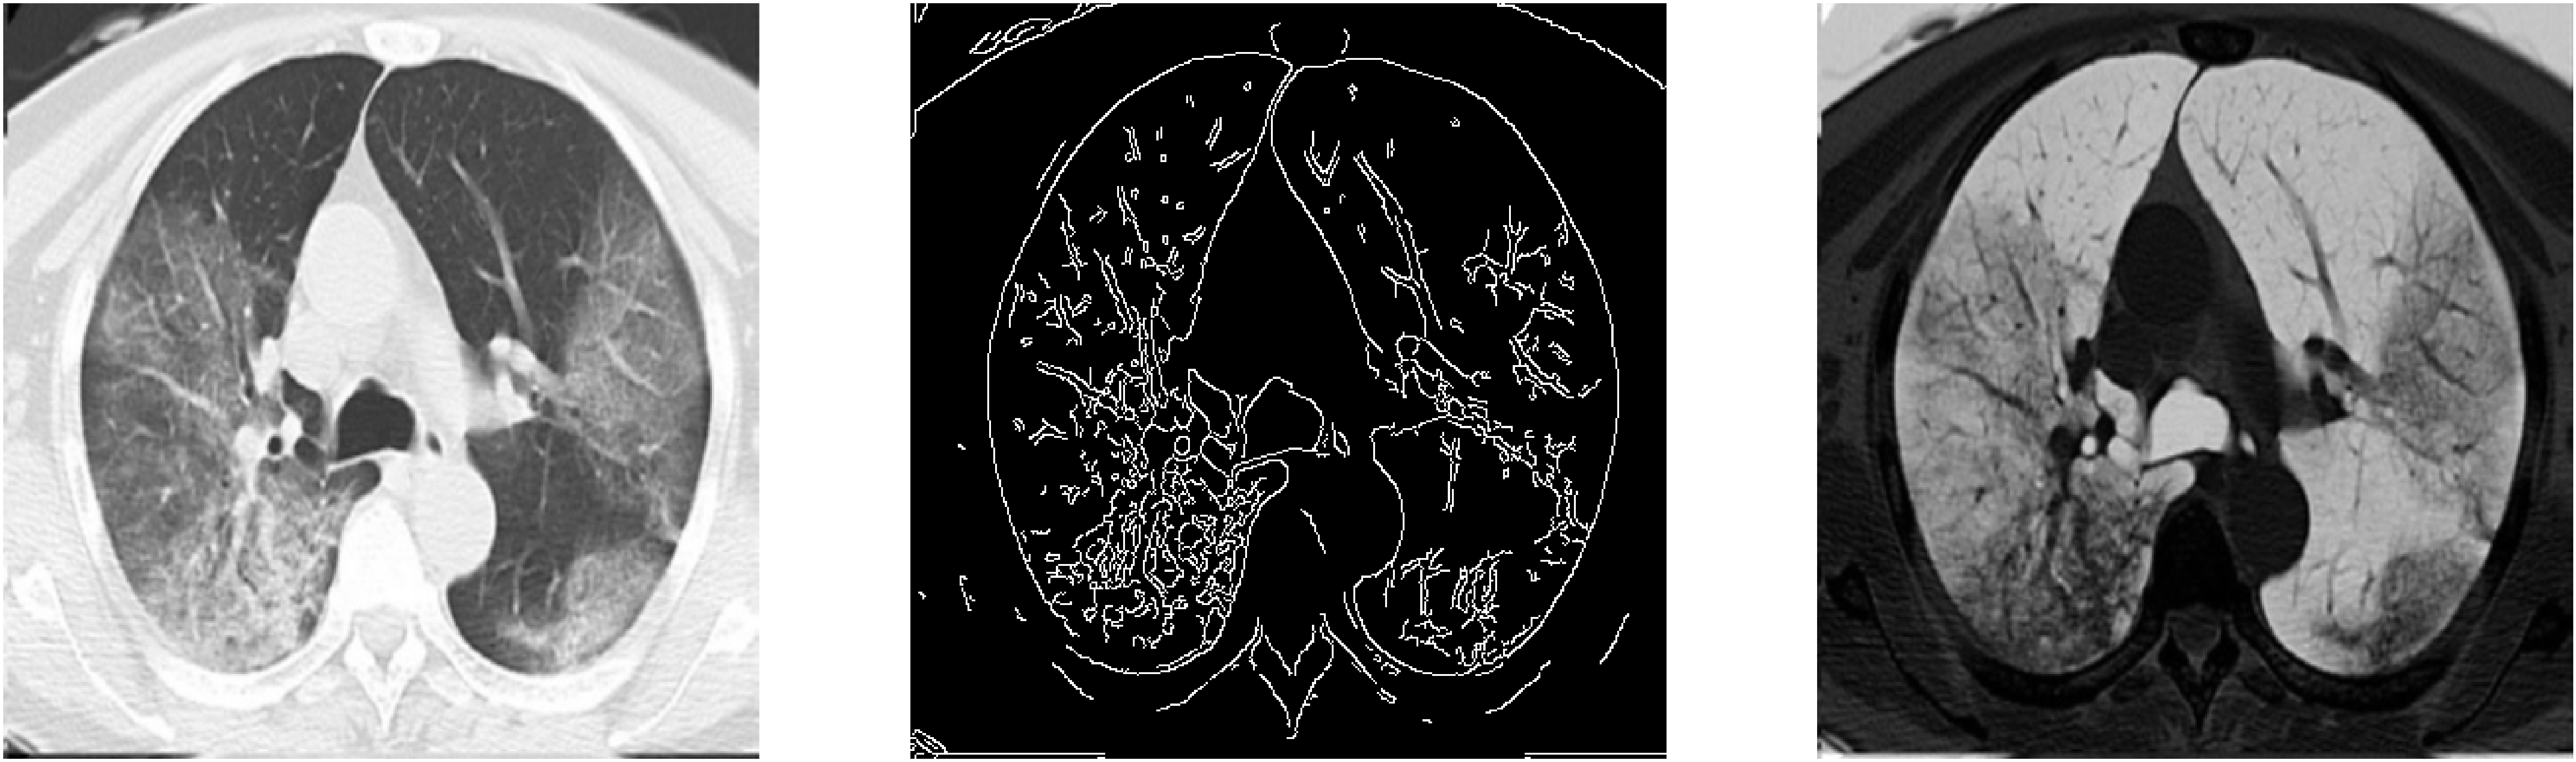

(384, 384, 3) (384, 384, 1) (384, 384, 4)


In [136]:
import matplotlib.pyplot as plt

cvimg = cv2.imread('/USER/data/train/31.png', cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
gray= cv2.imread('/USER/data/train/31.png', 0).reshape(384, 384,1)
print(type(cvimg))
a = (255-gray)
canny = cv2.Canny(a, 100,200)

output = np.concatenate((cvimg, a), axis =2)


fig = plt.figure(figsize=(100,100))
rows = 1
cols = 3
ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(cv2.cvtColor(cvimg, cv2.COLOR_BGR2RGB))
ax1.axis("off")
 
ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(cv2.cvtColor(canny, cv2.COLOR_BGR2RGB))
ax2.axis("off")

ax3 = fig.add_subplot(rows, cols, 3)
ax3.imshow(cv2.cvtColor(a, cv2.COLOR_BGR2RGB))
ax3.axis("off")

plt.show()

print(cvimg.shape, gray.shape, output.shape)

In [27]:
cvimg.shape

(384, 384, 3)

In [34]:
gray.shape

(384, 384, 1)

## Dataloader

#### Train & Validation Set loader

In [96]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, mode, input_shape):
        self.data_dir = data_dir
        self.mode = mode
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Dataset split
        if self.mode == 'train':
            self.db = self.db[:int(len(self.db) * 0.9)]
        elif self.mode == 'val':
            self.db = self.db[int(len(self.db) * 0.9):]
            self.db.reset_index(inplace=True)
        else:
            print(f'!!! Invalid split {self.mode}... !!!')
            
        # Transform function
        self.transform = transforms.Compose([transforms.Resize(self.input_shape),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406, 0.5], [0.229, 0.224, 0.225, 0.5])],
                                           )

    def data_loader(self):
        print('Loading ' + self.mode + ' dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        
        # (COVID : 1, No : 0)
        db = pd.read_csv(os.path.join(self.data_dir, 'train.csv'))
        
        return db

    def __len__(self):
        return len(self.db)

    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])

        # Loading image
        cvimg = cv2.imread(os.path.join(self.data_dir,'train',data['file_name']), cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        gray = cv2.imread(os.path.join(self.data_dir,'train',data['file_name']), 0)
        gray = (255- gray).reshape(384,384,1)
        concat_image = np.concatenate((cvimg, gray), axis =2)
        # canny = cv2.Canny(gray, 100,200)
        
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['file_name'])

        # Preprocessing images
        out_image = self.transform(Image.fromarray(concat_image))
        
        return out_image, data['COVID']


NameError: name 'cv2' is not defined

## Model

In [107]:
import torch.nn.functional as F

class custom_CNN(nn.Module):
    def __init__(self, num_classes):
        super(custom_CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=25, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=25, out_channels=50, kernel_size=7)
        
        self.fc1 = nn.Linear(in_features=50*28*28, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # print(x.shape)
        x = self.pool(F.relu(self.conv1(x))) # (32, 3, 128, 128) -> (32, 8, 62, 62)
        # print(x.shape)
        x = self.pool(F.relu(self.conv2(x))) # (32, 8, 62, 62) -> (32, 25, 29, 29)
        # print(x.shape)
        x = self.pool(F.relu(self.conv3(x))) 
        # print(x.shape)
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        output = self.softmax(x)
        
        return output

## Utils
### EarlyStopper

In [57]:
class LossEarlyStopper():
    """Early stopper
    
    Attributes:
        patience (int): loss가 줄어들지 않아도 학습할 epoch 수
        patience_counter (int): loss 가 줄어들지 않을 때 마다 1씩 증가, 감소 시 0으로 리셋
        min_loss (float): 최소 loss
        stop (bool): True 일 때 학습 중단

    """

    def __init__(self, patience: int)-> None:
        self.patience = patience

        self.patience_counter = 0
        self.min_loss = np.Inf
        self.stop = False
        self.save_model = False

    def check_early_stopping(self, loss: float)-> None:
        """Early stopping 여부 판단"""  

        if self.min_loss == np.Inf:
            self.min_loss = loss
            return None

        elif loss > self.min_loss:
            self.patience_counter += 1
            msg = f"Early stopping counter {self.patience_counter}/{self.patience}"

            if self.patience_counter == self.patience:
                self.stop = True
                
        elif loss <= self.min_loss:
            self.patience_counter = 0
            self.save_model = True
            msg = f"Validation loss decreased {self.min_loss} -> {loss}"
            self.min_loss = loss
        
        print(msg)

### Trainer

In [108]:
class Trainer():
    """ epoch에 대한 학습 및 검증 절차 정의"""
    
    def __init__(self, loss_fn, model, device, metric_fn, optimizer=None, scheduler=None):
        """ 초기화
        """
        self.loss_fn = loss_fn
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.metric_fn = metric_fn

    def train_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 학습 절차"""
        
        self.model.train()
        train_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            
            img = img.to(self.device)
            # print(img.shape)
            label = label.to(self.device).float()
            
            pred = self.model(img)
            
            loss = self.loss_fn(pred[:,1], label)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            
            train_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.train_mean_loss = train_total_loss / batch_index
        self.train_score, f1 = self.metric_fn(y_pred=pred_lst, y_answer=target_lst)
        msg = f'Epoch {epoch_index}, Train loss: {self.train_mean_loss}, Acc: {self.train_score}, F1-Macro: {f1}'
        print(msg)

    def validate_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 검증 절차
        """
        self.model.eval()
        val_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).float()
            pred = self.model(img)
            
            loss = self.loss_fn(pred[:,1], label)
            val_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.val_mean_loss = val_total_loss / batch_index
        self.validation_score, f1 = self.metric_fn(y_pred=pred_lst, y_answer=target_lst)
        msg = f'Epoch {epoch_index}, Val loss: {self.val_mean_loss}, Acc: {self.validation_score}, F1-Macro: {f1}'
        print(msg)

### Metrics

In [59]:
from sklearn.metrics import accuracy_score, f1_score

def get_metric_fn(y_pred, y_answer):
    """ 성능을 반환하는 함수"""
    
    assert len(y_pred) == len(y_answer), 'The size of prediction and answer are not same.'
    accuracy = accuracy_score(y_answer, y_pred)
    f1 = f1_score(y_answer, y_pred, average='macro')
    return accuracy, f1

## Train
### 학습을 위한 객체 선언

#### Load Dataset & Dataloader

In [109]:
# Load dataset & dataloader
train_dataset = CustomDataset(data_dir=DATA_DIR, mode='train', input_shape=INPUT_SHAPE)
validation_dataset = CustomDataset(data_dir=DATA_DIR, mode='val', input_shape=INPUT_SHAPE)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
print('Train set samples:',len(train_dataset),  'Val set samples:', len(validation_dataset))

Loading train dataset..
Loading val dataset..
Train set samples: 581 Val set samples: 65


#### Load model and other utils

In [110]:
# Load Model
model = custom_CNN(NUM_CLS).to(DEVICE)

# # Save Initial Model
# torch.save(model.state_dict(), 'initial.pt')

# Set optimizer, scheduler, loss function, metric function
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler =  optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e5, max_lr=0.0001, epochs=EPOCHS, steps_per_epoch=len(train_dataloader))
loss_fn = nn.BCELoss()
metric_fn = get_metric_fn


# Set trainer
trainer = Trainer(loss_fn, model, DEVICE, metric_fn, optimizer, scheduler)

# Set earlystopper
early_stopper = LossEarlyStopper(patience=EARLY_STOPPING_PATIENCE)

In [102]:
model

custom_CNN(
  (conv1): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 25, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(25, 50, kernel_size=(7, 7), stride=(1, 1))
  (fc1): Linear(in_features=36450, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)

### epoch 단위 학습 진행

In [111]:
for epoch_index in tqdm(range(EPOCHS)):

    trainer.train_epoch(train_dataloader, epoch_index)
    trainer.validate_epoch(validation_dataloader, epoch_index)

    # early_stopping check
    early_stopper.check_early_stopping(loss=trainer.val_mean_loss)

    if early_stopper.stop:
        print('Early stopped')
        break

    if early_stopper.save_model:
        check_point = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict()
        }
        torch.save(check_point, 'best.pt')


  0% 0/30 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.7315881782107883, Acc: 0.5662650602409639, F1-Macro: 0.5558427375318529


  3% 1/30 [01:57<56:49, 117.57s/it]

Epoch 0, Val loss: 0.9882858693599701, Acc: 0.676923076923077, F1-Macro: 0.656084656084656
Epoch 1, Train loss: 0.6718272815148035, Acc: 0.6333907056798623, F1-Macro: 0.6226547992572197
Epoch 1, Val loss: 0.7825533300638199, Acc: 0.7538461538461538, F1-Macro: 0.749034749034749
Validation loss decreased 0.9882858693599701 -> 0.7825533300638199


  7% 2/30 [03:52<54:26, 116.65s/it]

Epoch 2, Train loss: 0.5987024621831046, Acc: 0.7074010327022375, F1-Macro: 0.706076657540769
Epoch 2, Val loss: 0.6558980196714401, Acc: 0.676923076923077, F1-Macro: 0.6431372549019607
Validation loss decreased 0.7825533300638199 -> 0.6558980196714401


 10% 3/30 [05:52<52:57, 117.70s/it]

Epoch 3, Train loss: 0.5109600341982312, Acc: 0.7831325301204819, F1-Macro: 0.7805522914218568
Epoch 3, Val loss: 0.632887214422226, Acc: 0.6615384615384615, F1-Macro: 0.622093023255814
Validation loss decreased 0.6558980196714401 -> 0.632887214422226


 13% 4/30 [07:50<51:04, 117.88s/it]

Epoch 4, Train loss: 0.49449648294183945, Acc: 0.7951807228915663, F1-Macro: 0.7931190285969054
Epoch 4, Val loss: 0.534154400229454, Acc: 0.8153846153846154, F1-Macro: 0.8153409090909092
Validation loss decreased 0.632887214422226 -> 0.534154400229454


 17% 5/30 [09:46<48:53, 117.33s/it]

Epoch 5, Train loss: 0.4148787988556756, Acc: 0.8192771084337349, F1-Macro: 0.8183277396760542
Epoch 5, Val loss: 0.7775463461875916, Acc: 0.7384615384615385, F1-Macro: 0.7362138935306756
Early stopping counter 1/10


 20% 6/30 [11:46<47:16, 118.20s/it]

Epoch 6, Train loss: 0.33492881970273125, Acc: 0.8674698795180723, F1-Macro: 0.8668387104455577
Epoch 6, Val loss: 0.8540245890617371, Acc: 0.7384615384615385, F1-Macro: 0.7321212121212122
Early stopping counter 2/10


 23% 7/30 [13:45<45:24, 118.44s/it]

Epoch 7, Train loss: 0.28235875856545234, Acc: 0.9053356282271945, F1-Macro: 0.9047384817183145
Epoch 7, Val loss: 0.6652694344520569, Acc: 0.7384615384615385, F1-Macro: 0.7362138935306756
Early stopping counter 3/10


 27% 8/30 [15:40<43:00, 117.30s/it]

Epoch 8, Train loss: 0.27738570587502587, Acc: 0.9001721170395869, F1-Macro: 0.8997656101275462
Epoch 8, Val loss: 0.6266743168234825, Acc: 0.7076923076923077, F1-Macro: 0.6934723256391164
Early stopping counter 4/10


 30% 9/30 [17:35<40:48, 116.58s/it]

Epoch 9, Train loss: 0.26757072491778267, Acc: 0.9036144578313253, F1-Macro: 0.9027429036037975
Epoch 9, Val loss: 0.6155109703540802, Acc: 0.8, F1-Macro: 0.8
Early stopping counter 5/10


 33% 10/30 [19:34<39:07, 117.39s/it]

Epoch 10, Train loss: 0.20170762379550272, Acc: 0.9294320137693631, F1-Macro: 0.9290249534450652
Epoch 10, Val loss: 1.9476269483566284, Acc: 0.7846153846153846, F1-Macro: 0.7833333333333334
Early stopping counter 6/10


 37% 11/30 [21:34<37:22, 118.05s/it]

Epoch 11, Train loss: 0.20274600055482653, Acc: 0.9397590361445783, F1-Macro: 0.9395979932335494
Epoch 11, Val loss: 0.7437314093112946, Acc: 0.7076923076923077, F1-Macro: 0.7051802339460491
Early stopping counter 7/10


 40% 12/30 [23:32<35:23, 117.98s/it]

Epoch 12, Train loss: 0.17394506103462642, Acc: 0.9432013769363167, F1-Macro: 0.9428737430167597
Epoch 12, Val loss: 0.5760751031339169, Acc: 0.7384615384615385, F1-Macro: 0.7374673319078165
Early stopping counter 8/10


 43% 13/30 [25:31<33:33, 118.46s/it]

Epoch 13, Train loss: 0.14270602352917194, Acc: 0.963855421686747, F1-Macro: 0.9636655479352109
Epoch 13, Val loss: 0.7306473851203918, Acc: 0.7538461538461538, F1-Macro: 0.7533206831119544
Early stopping counter 9/10


 47% 14/30 [27:31<31:43, 118.98s/it]

Epoch 14, Train loss: 0.14058560215764576, Acc: 0.9707401032702238, F1-Macro: 0.9706273326096977


 47% 14/30 [29:28<33:40, 126.29s/it]

Epoch 14, Val loss: 0.5561582343652844, Acc: 0.7538461538461538, F1-Macro: 0.7537878787878789
Early stopping counter 10/10
Early stopped


## Inference
### 모델 로드

In [113]:
TRAINED_MODEL_PATH = 'best.pt'

### Load dataset

In [129]:
class TestDataset(Dataset):
    def __init__(self, data_dir, input_shape):
        self.data_dir = data_dir
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Transform function
        self.transform = transforms.Compose([transforms.Resize(self.input_shape),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406,0.5], [0.229, 0.224, 0.225,0.5])])

    def data_loader(self):
        print('Loading test dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        
        db = pd.read_csv(os.path.join(self.data_dir, 'sample_submission.csv'))
        return db
    
    def __len__(self):
        return len(self.db)
    
    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])
        
        # Loading image
        cvimg = cv2.imread(os.path.join(self.data_dir,'test',data['file_name']), cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        gray = cv2.imread(os.path.join(self.data_dir,'test',data['file_name']), 0)
        gray = (255- gray).reshape(384,384,1)
        concat_image = np.concatenate((cvimg, gray), axis =2)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['file_name'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(concat_image))

        return trans_image, data['file_name']

In [130]:
# Load dataset & dataloader
test_dataset = TestDataset(data_dir=DATA_DIR, input_shape=INPUT_SHAPE)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Loading test dataset..


### 추론 진행

In [131]:
model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

# Prediction
file_lst = []
pred_lst = []
prob_lst = []
model.eval()
with torch.no_grad():
    for batch_index, (img, file_num) in tqdm(enumerate(test_dataloader)):
        img = img.to(DEVICE)
        pred = model(img)
        print(pred)
        file_lst.extend(list(file_num))
        pred_lst.extend(pred.argmax(dim=1).tolist())
        prob_lst.extend(pred[:, 1].tolist())

1it [00:05,  5.52s/it]

tensor([[8.2888e-01, 1.7112e-01],
        [4.0006e-01, 5.9994e-01],
        [2.8073e-01, 7.1927e-01],
        [6.2969e-01, 3.7031e-01],
        [9.6923e-01, 3.0766e-02],
        [1.3602e-03, 9.9864e-01],
        [1.8607e-04, 9.9981e-01],
        [5.8136e-01, 4.1864e-01],
        [9.9897e-01, 1.0263e-03],
        [4.1784e-06, 1.0000e+00],
        [6.9600e-01, 3.0400e-01],
        [6.6599e-01, 3.3401e-01],
        [5.7454e-01, 4.2546e-01],
        [9.8933e-01, 1.0665e-02],
        [8.5993e-01, 1.4007e-01],
        [4.3820e-01, 5.6180e-01],
        [1.7098e-01, 8.2902e-01],
        [9.8324e-01, 1.6762e-02],
        [3.5826e-01, 6.4174e-01],
        [9.2640e-01, 7.3601e-02],
        [9.9701e-01, 2.9864e-03],
        [8.3015e-01, 1.6985e-01],
        [8.9638e-01, 1.0362e-01],
        [4.6831e-01, 5.3169e-01],
        [9.9922e-01, 7.7888e-04],
        [8.9441e-01, 1.0559e-01],
        [9.1261e-01, 8.7393e-02],
        [8.2039e-01, 1.7961e-01],
        [5.6404e-03, 9.9436e-01],
        [4.191

2it [00:11,  5.72s/it]

tensor([[2.6404e-01, 7.3596e-01],
        [8.9143e-01, 1.0857e-01],
        [9.5572e-01, 4.4285e-02],
        [5.7387e-02, 9.4261e-01],
        [3.0919e-03, 9.9691e-01],
        [1.2421e-01, 8.7579e-01],
        [4.4459e-06, 1.0000e+00],
        [3.0338e-02, 9.6966e-01],
        [2.2489e-04, 9.9978e-01],
        [6.0567e-01, 3.9433e-01],
        [5.9970e-01, 4.0030e-01],
        [3.8423e-04, 9.9962e-01],
        [6.5702e-02, 9.3430e-01],
        [3.6530e-01, 6.3470e-01],
        [5.9731e-01, 4.0269e-01],
        [9.9981e-01, 1.8668e-04],
        [7.8971e-01, 2.1029e-01],
        [6.8643e-01, 3.1357e-01],
        [5.2820e-01, 4.7180e-01],
        [4.8383e-04, 9.9952e-01],
        [1.1899e-02, 9.8810e-01],
        [6.9712e-01, 3.0288e-01],
        [5.1767e-03, 9.9482e-01],
        [6.6519e-01, 3.3481e-01],
        [1.8270e-01, 8.1730e-01],
        [5.3851e-05, 9.9995e-01],
        [9.9860e-01, 1.4026e-03],
        [5.9650e-01, 4.0350e-01],
        [1.7330e-03, 9.9827e-01],
        [9.892

3it [00:18,  6.05s/it]

tensor([[6.2953e-01, 3.7047e-01],
        [1.9296e-05, 9.9998e-01],
        [9.9944e-01, 5.6429e-04],
        [8.6702e-01, 1.3298e-01],
        [5.3842e-04, 9.9946e-01],
        [8.5795e-01, 1.4205e-01],
        [8.3998e-02, 9.1600e-01],
        [9.9015e-01, 9.8515e-03],
        [5.7981e-01, 4.2019e-01],
        [9.9105e-01, 8.9481e-03],
        [8.6223e-02, 9.1378e-01],
        [9.9967e-01, 3.3387e-04],
        [9.8449e-01, 1.5514e-02],
        [9.9134e-01, 8.6628e-03],
        [4.7456e-01, 5.2544e-01],
        [2.1489e-03, 9.9785e-01],
        [9.0038e-01, 9.9624e-02],
        [1.3143e-01, 8.6857e-01],
        [9.3253e-01, 6.7474e-02],
        [7.2572e-01, 2.7428e-01],
        [2.0912e-01, 7.9088e-01],
        [5.6538e-01, 4.3462e-01],
        [2.1235e-01, 7.8765e-01],
        [1.1881e-02, 9.8812e-01],
        [7.0129e-01, 2.9871e-01],
        [5.9890e-01, 4.0110e-01],
        [9.1072e-01, 8.9278e-02],
        [3.5091e-01, 6.4909e-01],
        [9.6074e-01, 3.9262e-02],
        [3.215

4it [00:19,  4.83s/it]

tensor([[1.8787e-03, 9.9812e-01],
        [8.3277e-02, 9.1672e-01],
        [6.9874e-04, 9.9930e-01],
        [4.4432e-01, 5.5568e-01]], device='cuda:0')


### 결과 저장

In [132]:
df = pd.DataFrame({'file_name':file_lst, 'COVID':pred_lst})
# df.sort_values(by=['file_name'], inplace=True)
df.to_csv('prediction.csv', index=False)